# Why using power cannot remove the background consistent noise?

* [Unable to remove audio noise using weak signal power calculated from FFT as threshold](https://dsp.stackexchange.com/questions/94622/unable-to-remove-audio-noise-using-weak-signal-power-calculated-from-fft-as-thre)

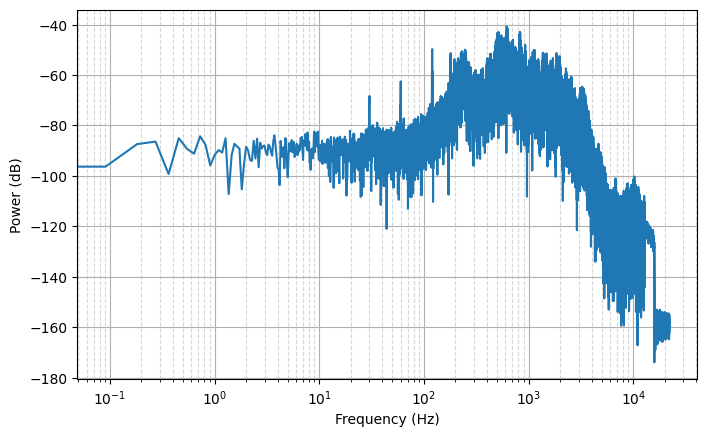

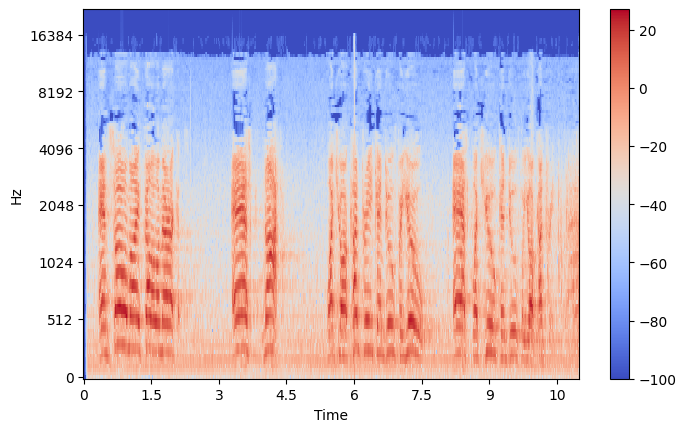

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from IPython.display import (
    Audio, 
    display
)

data, original_sampling_rate = librosa.load("./data/jfk.flac", sr=None)
sampling_rate = original_sampling_rate
N = num_total_samples = data.shape[0]


# sampling_rate = 8192
# data = librosa.resample(y=data, orig_sr=original_sampling_rate, target_sr=sampling_rate, scale=False)
# data = data * (data > 0.02)
# data, sampling_rate = librosa.load("/home/eml/home/repository/data/ml/LibriSpeechNoiseDataset/train/19-198-0003.wav", sr-None)
display(Audio(data=data, rate=sampling_rate))


# --------------------------------------------------------------------------------
# Power per Frequency in the original speech.
# --------------------------------------------------------------------------------
dft = np.fft.rfft(data, norm="forward")
amplitude = 2 * np.abs(dft)
db = 20 * np.log10(amplitude)
frequency = np.fft.rfftfreq(n=len(data), d=1/sampling_rate)

plt.figure().set_figwidth(8)
plt.plot(frequency, db)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.xscale("log")

# --------------------------------------------------------------------------------
# Mel Spectrogram
# --------------------------------------------------------------------------------
S = librosa.feature.melspectrogram(
    y=data, sr=sampling_rate, n_mels=128, fmax=sampling_rate/2, n_fft=1024, hop_length=512
)
S_dB = librosa.power_to_db(S, ref=1, top_db=None, amin=1e-10)

plt.figure().set_figwidth(8)
librosa.display.specshow(S_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=sampling_rate/2)
plt.colorbar()

In [2]:
def butter_bandpass(
    lowcut,
    highcut,
    sampling_rate: int,
    order: int = 5
):
    """
    Args:
        signal: signal data to filter
        lowcut: low cut-off frequency
        highcut: high cut-off frequency
        sampling_rate: sampling rate used to sample the signal
        order: filter order
    Returns: filtered output
    """
    nyquist = 0.5 * sampling_rate
    low = lowcut / nyquist
    high = highcut / nyquist
    sos = sp.signal.butter(N=order, Wn=[low, high], btype='band', analog=False, output='sos')
    return sos


def butter_bandpass_filter(
    signal: np.ndarray,
    lowcut,
    highcut,
    sampling_rate: int,
    order: int = 5
):
    """Butterworth bandpath filter
    Args:
        signal: signal data to filter
        lowcut: low cut-off frequency
        highcut: high cut-off frequency
        sampling_rate: sampling rate used to sample the signal
        order: filter order
    """
    sos = butter_bandpass(
        lowcut=lowcut,
        highcut=highcut,
        sampling_rate=sampling_rate, order=order)
    y = sp.signal.sosfilt(sos=sos, x=signal)
    return y

/tmp/ipykernel_70839/2283096573.py:22: RuntimeWarning: divide by zero encountered in log10
  plt.plot(frequency, 20 * np.log10(2 * np.abs(fhat_power_filtered)))


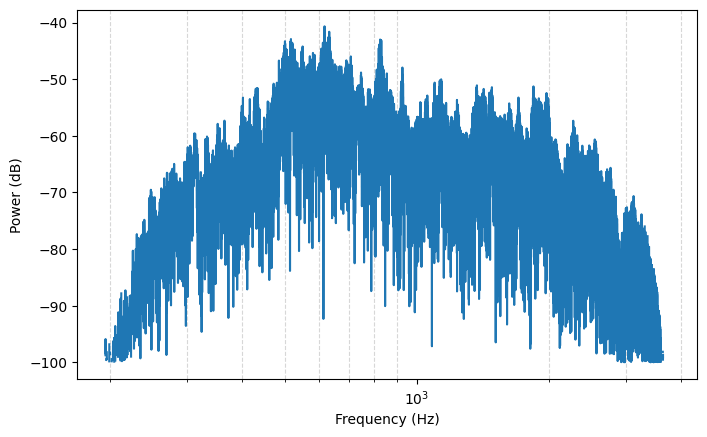

In [3]:
# --------------------------------------------------------------------------------
# Cut low/high frequencies with scipy.signal.butterworth
# --------------------------------------------------------------------------------
HIGHCUT = 3000
LOWCUT = 300
ORDER = 10
bandpassed = butter_bandpass_filter(signal=data, lowcut=LOWCUT, highcut=HIGHCUT, sampling_rate=sampling_rate, order=ORDER)

# --------------------------------------------------------------------------------
# Cut low power < -100 dB
# --------------------------------------------------------------------------------
THRESHOLD = -100
fhat = np.fft.rfft(a=bandpassed, norm="forward", axis=-1)
fhat_amplitude = 2 * np.abs(fhat)
fhat_power = 20 * np.log10(fhat_amplitude)

# zero out < -100 dB
fhat_filter_indices = fhat_power > THRESHOLD
fhat_power_filtered = fhat * fhat_filter_indices

plt.figure().set_figwidth(8)
plt.plot(frequency, 20 * np.log10(2 * np.abs(fhat_power_filtered)))
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor', linestyle='--', alpha=0.5)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power (dB)")
plt.grid()
plt.xscale("log")

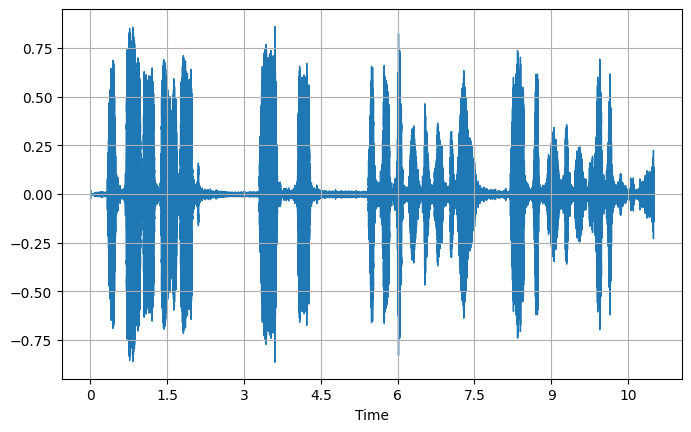

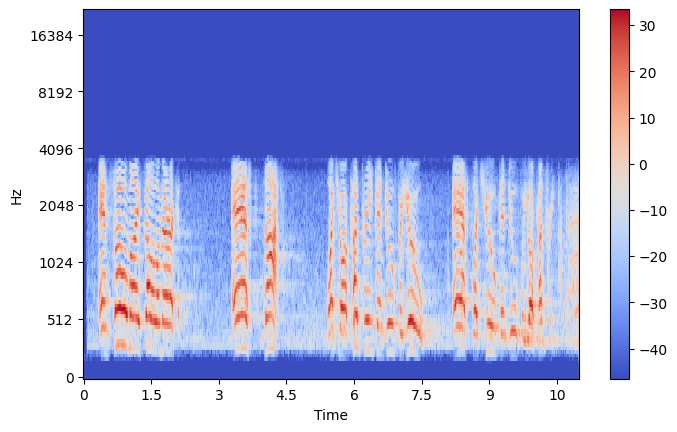

In [4]:
data_filtered = np.fft.irfft(fhat_power_filtered, norm="forward")
plt.figure().set_figwidth(8)
plt.grid()
librosa.display.waveshow(y=data_filtered, sr=sampling_rate)

S_filtered = librosa.feature.melspectrogram(y=data_filtered, sr=sampling_rate, n_mels=128, fmax=sampling_rate/2)
S_filtered_dB = librosa.power_to_db(S_filtered)

plt.figure().set_figwidth(8)
librosa.display.specshow(S_filtered_dB, x_axis="time", y_axis="mel", sr=sampling_rate, fmax=sampling_rate/2)
plt.colorbar()

In [5]:
from IPython.display import (
    Audio, 
    display
)
display(Audio(data=data_filtered, rate=sampling_rate))